# Neural Networks

#### Ashish Vinodkumar

# Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

#### **Part a** 

Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). Jupyter is great, but not always the easiest for debugging. There are a number of IDE's out there and something like PyCharm or Spyder. For a video on using and debugging in Spyder, see [my video on this topic](https://www.youtube.com/watch?v=zYNRqVimU3Q).
- *Unit tests*. I would strongly encourage you to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar).

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import metrics

In [2]:
class myNeuralNetwork(object):
    
    def __init__(self, n_in, n_layer1, n_layer2, n_out, learning_rate=0.01):
        '''__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs, 
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        '''
        self.n_in = n_in
        self.n_layer1 = n_layer1
        self.n_layer2 = n_layer2
        self.n_out = n_out
        self.learning_rate = learning_rate
        self.w1 = np.random.randn(self.n_in, self.n_layer1)
        self.w2 = np.random.randn(self.n_layer1, self.n_layer2)
        self.wo = np.random.randn(self.n_layer2, self.n_out)
        
            
    def forward_propagation(self, x):
        '''forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        '''
        
        self.layer_a1 = np.dot(x, self.w1)
        self.layer_z1 = self.sigmoid(self.layer_a1)
        
        self.layer_a2 = np.dot(self.layer_z1, self.w2)
        self.layer_z2 = self.sigmoid(self.layer_a2)
        
        self.layer_a3 = np.dot(self.layer_z2, self.wo)
        self.layer_z3 = self.sigmoid(self.layer_a3).ravel()
        
        return self.layer_z3
        
    
    def compute_loss(self, X, y):
        '''compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        '''
        
        #y_pred = self.layer_z3
        y_pred = self.predict_proba(X)
        cost = 0.5*np.sum(((y_pred - y)**2))
        return cost
        
    def backpropagate(self, x, y):
        '''backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations 
               Corresponding to x and get the loss functionof the model 
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network
    
            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        '''
        y_pred = self.forward_propagation(x)
        delta_d3 = (y_pred - y) * self.sigmoid_derivative(self.layer_a3)
        self.layer_d3 = np.dot(np.matrix(self.layer_z2).T, delta_d3)

        delta_d2 = np.dot(delta_d3, self.wo.T) * self.sigmoid_derivative(
            self.layer_a2)
        self.layer_d2 = np.dot(self.layer_z1.T, delta_d2)
        
        delta_d1 = np.dot(delta_d2, self.w2.T) * self.sigmoid_derivative(
            self.layer_a1)
        self.layer_d1 = np.dot(x.T, delta_d1)
        
        return self.compute_loss(x,y)
        
        
    def stochastic_gradient_descent_step(self):
        '''stochastic_gradient_descent_step
        Using the gradient values computed by backpropagate, update each
        weight value of the model according to the familiar stochastic
        gradient descent update equation.
        
        Input: none
        Output: none
        '''
        self.wo -= self.learning_rate * self.layer_d3
        self.w2 -= self.learning_rate * self.layer_d2
        self.w1 -= self.learning_rate * self.layer_d1
        
        
    
    def fit(self, X, y, max_epochs=5000, learning_rate=0.01, 
            get_validation_loss=False):
        '''fit
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                training_loss:   Vector of training loss values at the end of each epoch
                validation_loss: Vector of validation loss values at the end of each epoch
                                 [optional output if get_validation_loss==True]
        '''
        self.learning_rate = learning_rate
        self.cost_training = []
        self.cost_val = []
        
        
        index = np.arange(len(train_x))
        np.random.shuffle(index)
        X = X[index]
        y = y[index]
        
        if get_validation_loss:
            ind = int(0.80*len(train_x))
            X_val = X[ind:]
            y_val = y[ind:]
            X = X[:ind]
            y = y[:ind]
        
        for i in range(max_epochs):
            cost_train = 0
            for record in range(len(X)):
                y_pred = self.forward_propagation(X[record])
                cost_train += self.backpropagate(X[record].reshape([1,-1]), 
                                                 y[record].reshape([1,-1]))
                self.stochastic_gradient_descent_step()
                
            self.cost_training.append(cost_train/len(y))
            if get_validation_loss:
                self.cost_val.append((self.compute_loss(X_val, 
                                y_val))/len(y_val))
        
        return self.cost_training, self.cost_val
                
    
    def predict_proba(self, X):
        '''predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        '''
        
        layer_a1 = np.dot(X, self.w1)
        layer_z1 = self.sigmoid(layer_a1)
        
        layer_a2 = np.dot(layer_z1, self.w2)
        layer_z2 = self.sigmoid(layer_a2)
        
        layer_a3 = np.dot(layer_z2, self.wo)
        layer_z3 = self.sigmoid(layer_a3).ravel()
        return layer_z3
        

    def predict(self, X, decision_thresh=0.5):
        '''predict
        Compute the output of the neural network prediction for 
        each sample in X, with the last layer's sigmoid activation 
        providing an estimate of the target output between 0 and 1, 
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        '''
        
        y_pred = self.predict_proba(X)
        return np.where(y_pred >= decision_thresh, 1, 0)
        
        
    def sigmoid(self, X):
        '''sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        '''
        return 1 / (1 + np.exp(-X))
    
    
    def sigmoid_derivative(self, X):
        '''sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        '''
        sig_val = self.sigmoid(X)
        return sig_val * (1-sig_val)
        
        
        


In [3]:
n_train = 500
n_test = 100
train_x, train_y = make_moons(n_train, noise=0.20)
test_x, test_y = make_moons(n_test, noise=0.20)

In [4]:
# 2 input nodes, 2 hidden layers with 5 nodes each, and 1 output node.
n_in = 2
n_layer1 = 5
n_layer2 = 5
n_out = 1
learning_rate = 0.01
my_nn = myNeuralNetwork(n_in=n_in, n_layer1=n_layer1, 
        n_layer2=n_layer2, n_out=n_out, 
        learning_rate=learning_rate)

In [5]:
max_epochs = 5000
cost_training, cost_val = my_nn.fit(train_x, train_y, max_epochs=max_epochs, 
                          learning_rate=0.01, get_validation_loss=True)

#### **Part b** 

Apply your neural network. 
- Create a training and validation dataset using `sklearn.datasets.make_moons(N, noise=0.20)`, where $N_{train} = 500$ and $N_{test} = 100$. 
- Train and test your model on this dataset plotting your learning curves (training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time). 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. 
- In two subplots, plot the training data on one subplot, and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- Report your performance on the test data with an ROC curve and compare against the `scikit-learn` `MLPClassifier` trained with the same parameters.

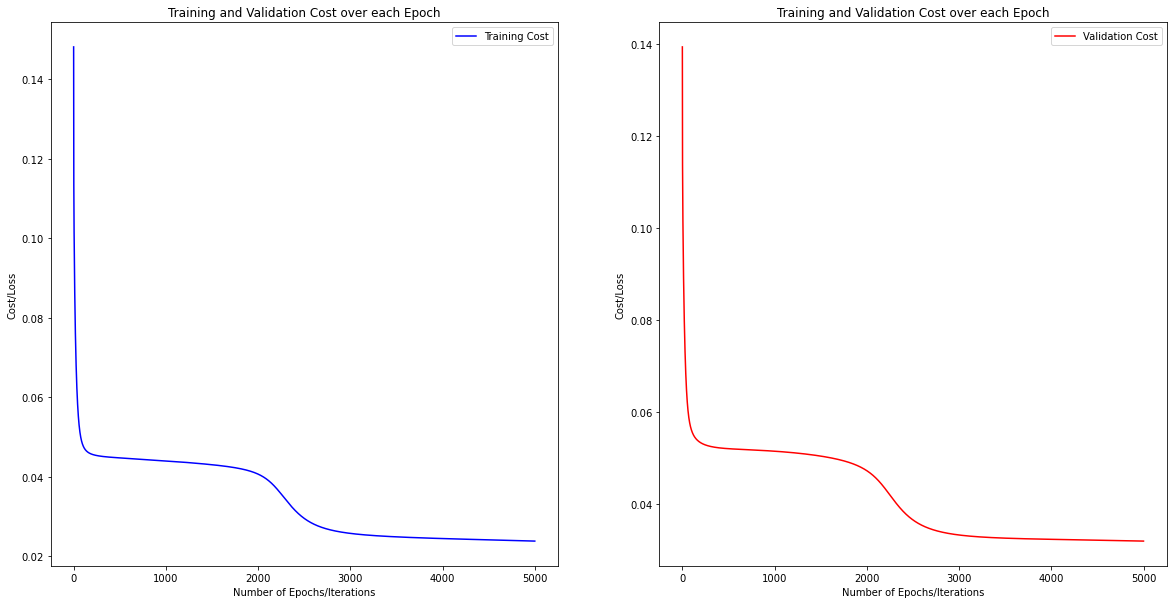

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(max_epochs), cost_training, c='b', label='Training Cost')
plt.legend()
plt.xlabel('Number of Epochs/Iterations')
plt.ylabel('Cost/Loss')
plt.title('Training and Validation Cost over each Epoch')

if len(cost_val) != 0:
    plt.subplot(1,2,2)
    plt.plot(range(max_epochs), cost_val, c='r', label='Validation Cost')
    plt.legend()
    plt.xlabel('Number of Epochs/Iterations')
    plt.ylabel('Cost/Loss')
    plt.title('Training and Validation Cost over each Epoch')
plt.show()

In [7]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
def plot_decision_boundary_graph_neural_network(X, y, title, p):
    plt.subplot(1,2,p)
    h = .02  # step size in the mesh
    # Create color maps
    cmap_light = ListedColormap(['orange','cornflowerblue'])
    cmap_bold = ['darkorange', 'darkblue']
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z1 = my_nn.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z1.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    
    # Plot also the training points
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                    palette=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('Featuer 1')
    plt.ylabel('Feature 2')


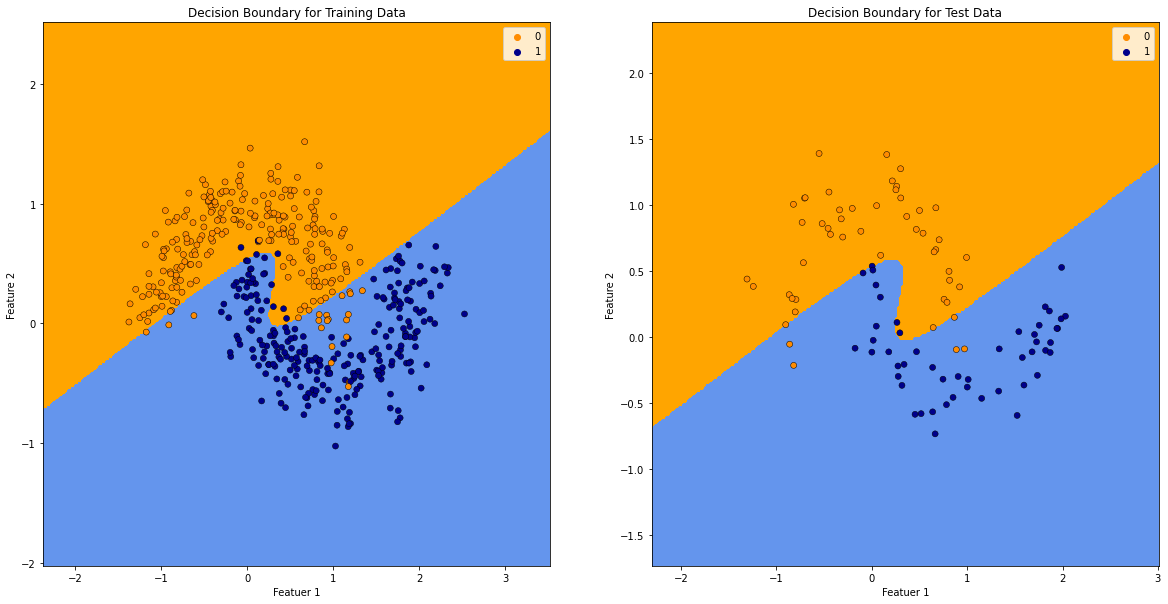

In [8]:
plt.figure(figsize=(20, 10))
plot_decision_boundary_graph_neural_network(train_x, train_y, 'Decision Boundary for Training Data',1)

plot_decision_boundary_graph_neural_network(test_x, test_y, 'Decision Boundary for Test Data',2)
plt.show()

- Report your performance on the test data with an ROC curve and compare against the `scikit-learn` `MLPClassifier` trained with the same parameters.

In [9]:
from sklearn.neural_network import MLPClassifier

In [10]:
clf = MLPClassifier(random_state=1, max_iter=5000, hidden_layer_sizes=(5,5), 
                   activation='logistic', solver='sgd', shuffle=True,
                   batch_size=1, learning_rate_init=0.01,
                   learning_rate='constant').fit(train_x, train_y)

In [11]:
y_pred_mlp = clf.predict(test_x)
y_pred_proba_mlp = clf.predict_proba(test_x)[:,1]
y_pred_mynn = my_nn.predict(test_x)
y_pred_proba_my_nn = my_nn.predict_proba(test_x)

In [12]:
fpr_mlp, tpr_mlp, thresholds_mlp = metrics.roc_curve(test_y, y_pred_proba_mlp, pos_label=1)
auc_mynn = metrics.roc_auc_score(test_y, y_pred_mynn)

fpr_mynn, tpr_mynn, thresholds_mynn = metrics.roc_curve(test_y, y_pred_proba_my_nn, pos_label=1)
auc_mlp = metrics.roc_auc_score(test_y, y_pred_mlp)

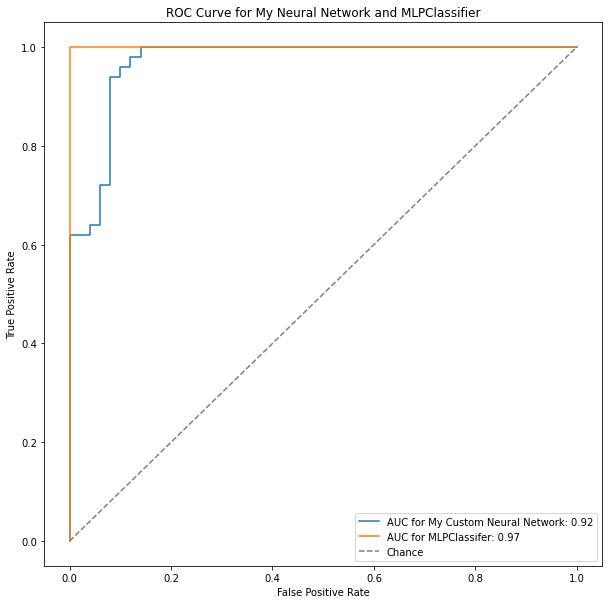

In [13]:
plt.figure(figsize=(10, 10))
lab1 = 'AUC for My Custom Neural Network: '+str(round(auc_mynn,4))
plt.plot(fpr_mynn,tpr_mynn, label=lab1)

lab2 = 'AUC for MLPClassifer: '+str(round(auc_mlp,4))
plt.plot(fpr_mlp,tpr_mlp, label=lab2)
xlabel = 'False Positive Rate'
ylabel = 'True Positive Rate'
title = 'ROC Curve for My Neural Network and MLPClassifier'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
# Add chance default line.
plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
plt.legend()

**Precision-Recall-F1 Table for My Neural Network**

In [14]:
print(metrics.classification_report(test_y, y_pred_mynn))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92        50
           1       0.90      0.94      0.92        50

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



**Precision-Recall-F1 Table for MLP Classifier**

In [15]:
print(metrics.classification_report(test_y, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        50
           1       1.00      0.94      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [16]:
print(lab1)
print(lab2)

AUC for My Custom Neural Network: 0.92
AUC for MLPClassifer: 0.97


The AUC scores of my_neural_network is higher compared to the MLPClassifier as stated above. Furthermore, looking at my_neural_network, we notice that the precision and recall values for classifying both class-0 and class-1 are high with my neural network implementation compared to the MLP classifier. Overall, I believe my neural network implementation seems to perform better than the MLP Classifier.

#### **Part c**:  

We could improve upon this implementation by adding in regularization techniques such as early stopping or drop out to improve the model performance. Also, my neural network runs relatively slowly compared to the Scikit Learn MLP Classifier. We could improve upon this by optimizing the codebase to execute the algorithm faster. Also, we could experiment with adding in a bias term to my neural network implementation. Another approach for improving my neural network could be to look at different types of activation functions instead of just sigmoid. Maybe a tanh or relu activation function could improve the overall model performance.